# CSOC-IG 2025: Neural Network Project (Jupyter Notebook)

**Objective:**  
- Build and evaluate two models (vanilla NumPy and PyTorch) to predict patient no-shows.

---

## 1. Setup & Imports




In [61]:
# 1.1 For neural network from scratch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
)

# 1.2 For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## 2. Load & Explore Dataset

In [62]:
df = pd.read_csv("KaggleV2-May-2016.csv")


print("Shape:", df.shape)
df.head()

print(df.columns)


Shape: (110527, 14)
Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')


## 3. Preprocessing

In [63]:

df.columns = df.columns.str.strip()

#  Converting “No-show” to numeric target (No → 0, Yes → 1)
df["No-show"] = df["No-show"].map({"No": 0, "Yes": 1})

# Gender (F → 0, M → 1)
df["Gender"] = df["Gender"].map({"F": 0, "M": 1})

df["ScheduledDay"]   = pd.to_datetime(df["ScheduledDay"])
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"])
df["waiting_days"]   = (df["AppointmentDay"] - df["ScheduledDay"]).dt.days.clip(lower=0)

le = LabelEncoder()
df["Neighbourhood_enc"] = le.fit_transform(df["Neighbourhood"])

# Dropping columns we no longer need
df = df.drop(columns=[
    "PatientId",   
    "AppointmentID",  
    "Neighbourhood"  
])

# Removing any rows where Age < 0
df = df[df["Age"] >= 0]

features = [
    "Gender", "Age", "Scholarship", "Hipertension", "Diabetes",
    "Alcoholism", "Handcap", "SMS_received", "waiting_days", "Neighbourhood_enc"
]
X = df[features].values
y = df["No-show"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)


print("X_train shape:", X_train.shape)
print("X_val   shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val   shape:", y_val.shape)

X_train shape: (88420, 10)
X_val   shape: (22106, 10)
y_train shape: (88420,)
y_val   shape: (22106,)


In [64]:
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,waiting_days,Neighbourhood_enc
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,0,0,39
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,0,0,0,39
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,0,0,0,0,0,45
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,0,0,0,0,0,54
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,1,0,0,0,0,0,39


## 4. Part 1: Neural Network from Scratch (NumPy)

### 4.1 Architecture & Hyperparameters

In [65]:
# 4.1.1 Activation functions + derivatives

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def leaky_relu_derivative(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)


# 4.1.2 Initialize parameters

def initialize_parameters(layer_dims):
   
    np.random.seed(42)
    parameters = {}
    for i in range(1, len(layer_dims)):
        parameters[f"W{i}"] = np.random.randn(layer_dims[i], layer_dims[i-1]) * np.sqrt(1 / layer_dims[i-1])
        parameters[f"b{i}"] = np.zeros((layer_dims[i], 1))
    return parameters


### 4.2 Forward & Backward Propagation

In [66]:
# 4.2.1 Forward propagation

def forward_propagation(X, parameters):
    caches = {}
    # Layer 1
    Z1 = parameters["W1"].dot(X) + parameters["b1"]
    A1 = leaky_relu(Z1)
    # Layer 2
    Z2 = parameters["W2"].dot(A1) + parameters["b2"]
    A2 = leaky_relu(Z2)
    # Output layer
    Z3 = parameters["W3"].dot(A2) + parameters["b3"]
    A3 = sigmoid(Z3)

    caches["Z1"], caches["A1"] = Z1, A1
    caches["Z2"], caches["A2"] = Z2, A2
    caches["Z3"], caches["A3"] = Z3, A3
    return A3, caches

# 4.2.2 Computing loss

def compute_loss(A3, Y):
    m = Y.shape[1]
    eps = 1e-8
    loss = -np.sum(Y * np.log(A3 + eps) + (1 - Y) * np.log(1 - A3 + eps)) / m
    return loss

# 4.2.3 Backward propagation

def backward_propagation(X, Y, parameters, caches):
    m = X.shape[1]
    W1, W2, W3 = parameters["W1"], parameters["W2"], parameters["W3"]
    A1, A2, A3 = caches["A1"], caches["A2"], caches["A3"]
    Z1, Z2, Z3 = caches["Z1"], caches["Z2"], caches["Z3"]

    grads = {}

    # Output layer gradients
    dZ3 = A3 - Y
    grads["dW3"] = (1 / m) * dZ3.dot(A2.T)
    grads["db3"] = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

    # Layer 2 gradients
    dA2 = W3.T.dot(dZ3)
    dZ2 = dA2 * leaky_relu_derivative(Z2)
    grads["dW2"] = (1 / m) * dZ2.dot(A1.T)
    grads["db2"] = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # Layer 1 gradients
    dA1 = W2.T.dot(dZ2)
    dZ1 = dA1 * leaky_relu_derivative(Z1)
    grads["dW1"] = (1 / m) * dZ1.dot(X.T)
    grads["db1"] = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return grads


### 4.3 Training Loop (NumPy)

Predicted no-shows (1s): 5711 out of 22106
Predicted no-shows (1s): 6061 out of 22106
Predicted no-shows (1s): 5422 out of 22106
Predicted no-shows (1s): 5178 out of 22106
Predicted no-shows (1s): 5783 out of 22106


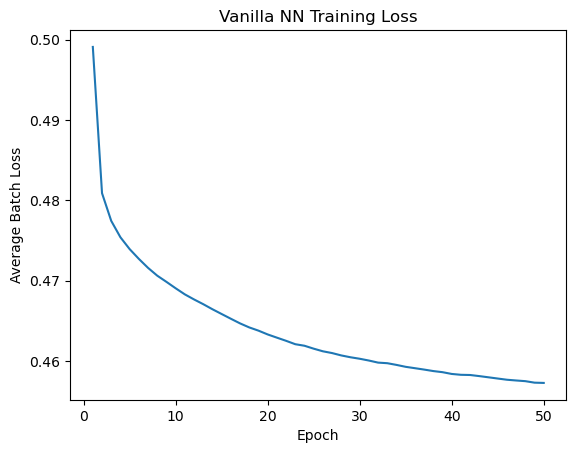

In [67]:
# 4.3.1 Helper to update parameters

def update_parameters(parameters, grads, learning_rate):
    for i in [1, 2, 3]:
        parameters[f"W{i}"] -= learning_rate * grads[f"dW{i}"]
        parameters[f"b{i}"] -= learning_rate * grads[f"db{i}"]
    return parameters

# 4.3.2 Converting data to shapes (features, samples)
X_train_T = X_train.T  # shape is (n_features, m_train)
y_train_T = y_train.reshape(1, -1)

X_val_T = X_val.T
y_val_T = y_val.reshape(1, -1)

# 4.3.3 Initializing this
layers_dims = [X_train_T.shape[0], 16, 8, 1]
parameters = initialize_parameters(layers_dims)

# 4.3.4 Hyperparameters
learning_rate = 0.01
num_epochs = 50
batch_size = 64
m = X_train_T.shape[1]
num_batches = m // batch_size

# 4.3.5 Training
losses = []
for epoch in range(num_epochs):
    permutation = np.random.permutation(m)
    X_shuffled = X_train_T[:, permutation]
    Y_shuffled = y_train_T[:, permutation]

    epoch_loss = 0
    for b in range(num_batches):
        start = b * batch_size
        end = start + batch_size
        X_batch = X_shuffled[:, start:end]
        Y_batch = Y_shuffled[:, start:end]

        # Forward
        A3, caches = forward_propagation(X_batch, parameters)

        # Computing loss
        batch_loss = compute_loss(A3, Y_batch)
        epoch_loss += batch_loss

        # Backward
        grads = backward_propagation(X_batch, Y_batch, parameters, caches)

        # Update
        parameters = update_parameters(parameters, grads, learning_rate)

    losses.append(epoch_loss / num_batches)
    if (epoch + 1) % 10 == 0:
        pred_sample, _ = predict_numpy(X_val_T, parameters, threshold=0.3)
        print(f"Predicted no-shows (1s): {np.sum(pred_sample)} out of {len(pred_sample)}")


# 4.3.6 Plot 
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Average Batch Loss")
plt.title("Vanilla NN Training Loss")
plt.show()


### 4.4 Evaluation (NumPy Model)

In [68]:
# 4.4.1 Predict function

def predict_numpy(X, parameters, threshold=0.5):
    A3, _ = forward_propagation(X, parameters)
    preds = (A3 >= threshold).astype(int)
    return preds.flatten(), A3.flatten()

# 4.4.2 On Validation Set
y_pred_val, y_prob_val = predict_numpy(X_val_T, parameters, threshold=0.3)
acc_np = accuracy_score(y_val, y_pred_val)
f1_np = f1_score(y_val, y_pred_val)
precision_np, recall_np, _ = precision_recall_curve(y_val, y_prob_val)
pr_auc_np = auc(recall_np, precision_np)
cm_np = confusion_matrix(y_val, y_pred_val)

print("NumPy Model — Accuracy:", acc_np)
print("NumPy Model — F1 Score:", f1_np)
print("NumPy Model — PR-AUC:", pr_auc_np)
print("NumPy Confusion Matrix:\n", cm_np)


NumPy Model — Accuracy: 0.7213878584999548
NumPy Model — F1 Score: 0.398946032985264
NumPy Model — PR-AUC: 0.3460463729161636
NumPy Confusion Matrix:
 [[13903  3739]
 [ 2420  2044]]


## 5. Part 2: PyTorch Implementation

### 5.1 Creating Torch Dataset & DataLoader

In [69]:
# 5.1.1 Converting to Torch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

# 5.1.2 Dataset & DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


### 5.2 Define PyTorch Model

In [71]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)


# Instantiation
input_dim = X_train.shape[1] 
model = SimpleNN(input_dim)


### 5.3 Training Loop (PyTorch)

Using pos_weight = 3.95
Epoch 10/50 | Loss: 0.9901
Epoch 20/50 | Loss: 0.9850
Epoch 30/50 | Loss: 0.9817
Epoch 40/50 | Loss: 0.9834
Epoch 50/50 | Loss: 0.9826


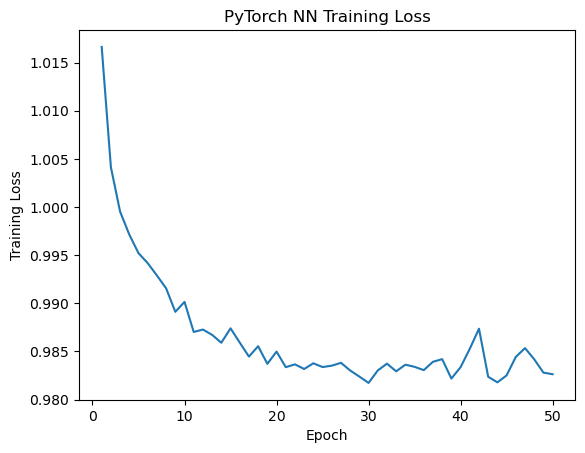

In [72]:
# Counting positives and negatives
num_pos = y_train.sum()
num_neg = len(y_train) - num_pos
pos_weight_value = num_neg / num_pos
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(f"Using pos_weight = {pos_weight.item():.2f}")

num_epochs = 50
losses_torch = []

# 5.3.2 Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    losses_torch.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f}")

# 5.3.3 Plot
plt.plot(range(1, num_epochs+1), losses_torch)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("PyTorch NN Training Loss")
plt.show()


### 5.4 Evaluation (PyTorch Model)

In [73]:
model.eval()
all_probs = []
all_preds = []
all_labels = []

threshold = 0.3 

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch).flatten()
        probs = torch.sigmoid(outputs).tolist() 

        preds = (torch.tensor(probs) >= threshold).int().tolist()


        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(y_batch.flatten().int().tolist())

# Computing evaluation metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)
cm = confusion_matrix(all_labels, all_preds)

print("PyTorch Model — Accuracy:", acc)
print("PyTorch Model — F1 Score:", f1)
print("PyTorch Model — PR-AUC:", pr_auc)
print("PyTorch Confusion Matrix:\n", cm)

PyTorch Model — Accuracy: 0.5114448566000181
PyTorch Model — F1 Score: 0.42638623326959846
PyTorch Model — PR-AUC: 0.3494199114590649
PyTorch Confusion Matrix:
 [[ 7292 10350]
 [  450  4014]]


### 6. Part 3: Comparison & Discussion

In [76]:

metrics_df = pd.DataFrame({
    "Model": ["NumPy NN", "PyTorch NN"],
    "Accuracy": [acc_np, acc],
    "F1 Score": [f1_np, f1],
    "PR-AUC": [pr_auc_np, pr_auc]
})
metrics_df


,Model,Accuracy,F1 Score,PR-AUC
0,NumPy NN,0.721388,0.398946,0.346046
1,PyTorch NN,0.511445,0.426386,0.349420
